In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41577")
client

<Client: 'tcp://127.0.0.1:41577' processes=10 threads=50, memory=196.70 GiB>

In [2]:
client.restart()

Connection method: Direct,
Dashboard: http://127.0.0.1:8787/status,
Comm: tcp://127.0.0.1:41577,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: 3 hours ago,Total memory: 0 B


In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
# import gc
# import h5py
import gsw
import time
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
from fastjmd95 import drhods, drhodt
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ddir = '/tank/chaocean/'
topog = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA/'
spec = '/tank/spectre/tuchida/TWA'

In [5]:
members = range(36,60)

grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 10
yend = 50

Dsig = 9.2
sigmin = 20.
nlayers = 55
# siglayers = np.linspace(19,48,nlayers)
xs, xe = (0,2)
tanh1 = np.tanh(np.arange(xs, xe, (xe-xs)/nlayers))
amp = (tanh1.max()-tanh1.min())
siglayers = (tanh1-tanh1.min())*amp**-1*Dsig + sigmin
tanh2 = np.tanh(np.arange(xs-(xe-xs)/(2*nlayers), xe+(xe-xs)/(2*nlayers), (xe-xs)/nlayers))
sigp1layers = (tanh2-tanh1.min())*amp**-1*Dsig + sigmin
# func = interp1d(range(1,nlayers+1), siglayers, fill_value='extrapolate')
# sigp1layers = func(np.arange(.5,nlayers+1.5,1))
print(siglayers,sigp1layers)

[20.         20.34783626 20.69475465 21.03984695 21.38222406 21.72102502
 22.05542541 22.38464498 22.70795438 23.02468079 23.33421255 23.63600254
 23.92957049 24.21450415 24.49045938 24.75715929 25.01439246 25.26201041
 25.49992447 25.72810197 25.94656223 26.15537208 26.35464133 26.5445181
 26.72518415 26.89685039 27.05975242 27.21414639 27.36030499 27.49851386
 27.62906814 27.75226942 27.868423   27.97783536 28.08081204 28.17765574
 28.26866467 28.35413122 28.43434077 28.50957077 28.58009001 28.64615804
 28.70802471 28.76592996 28.82010358 28.87076516 28.91812416 28.96237991
 29.00372184 29.04232966 29.0783736  29.11201471 29.14340512 29.17268843
 29.2       ] [19.82602439 20.17397561 20.52146729 20.86758519 21.21142948 21.55212404
 21.88882517 22.22072965 22.54708189 22.86718016 23.18038174 23.48610686
 23.78384163 24.07313971 24.35362294 24.62498098 24.88696994 25.13941024
 25.38218374 25.61523025 25.83854364 26.05216754 26.25619087 26.45074315
 26.63598991 26.81212805 26.97938136 2

In [6]:
def sound_speed(s,th,p):
    """
    s            : salinity (psu)
    th           : potential temperature (deg C, ITS-90)
    p            : pressure (dbar)
    """
    th2 = th**2
    sqrts = np.sqrt(s)

    anum = ( 9.99843699e2 +
            th *( 7.35212840 +
                 th *(-5.45928211e-2 +
                      th * 3.98476704e-4
                     )
                ) +
            s *( 2.96938239 -
                th * 7.23268813e-3 +
                s * 2.12382341e-3
               )
           )
    aden = (1. +
            th *( 7.28606739e-3 +
                 th *(-4.60835542e-5 +
                      th *( 3.68390573e-7 +
                           th * 1.80809186e-10
                          )
                     )
                ) +
            s *( 2.14691708e-3 -
                th *( 9.27062484e-6 +
                     th2 * 1.78343643e-10
                    ) +
                sqrts *( 4.76534122e-6 +
                        th2 * 1.63410736e-9
                       )
               )
           )
    
#     anum_th =   (      7.352128400 + 
#                  th *(-1.091856422e-01 + 
#                  th *  1.195430112e-03) -
#                   s *  7.232688130e-03)

#     aden_th =   (      7.286067390e-03 +
#                  th *(-9.216710840e-05 + 
#                  th *( 1.105171719e-06 + 
#                  th *  7.232367440e-10)) +
#                   s *(-9.270624840e-06 - 
#                 th2 *  5.350309290e-10 + 
#           th *sqrts *  3.268214720e-09))

#     anum_s =    (      2.96938239 -
#                  th *  7.23268813e-03 +
#                   s *  4.24764682e-03)

#     aden_s =    (      2.14691708e-03 -
#                  th *( 9.27062484e-06 +
#                 th2 *  1.78343643e-10) +
#               sqrts *( 7.14801183e-06 + 
#                 th2 *  2.45116104e-09))

    anum_p = ( 1.04004591e-2 +
              th2 * 1.03970529e-7 +
              s * 5.18761880e-6
             )
    # aden_p = 5.30848875e-6 * xr.ones_like(s)
    aden_p = 5.30848875e-6 * np.ones_like(s)

#     s = s.where(p!=0.)
#     th = th.where(p!=0.) 
#     th2 = th2.where(p!=0.) 
#     p = p.where(p!=0.)
#     anum = anum.where(p!=0.)
#     aden = aden.where(p!=0.)
#     anum_p = anum_p.where(p!=0.)
#     aden_p = aden_p.where(p!=0.)

    pth = p*th
    anum = anum + p *( 1.04004591e-2 +
                      th2 *  1.03970529e-7 +
                      s *  5.18761880e-6 -
                      p *( 3.24041825e-8 +
                          th2 *  1.23869360e-11
                         )
                     )
    aden = aden + p *( 5.30848875e-6 -
                      pth *(th2 *  3.03175128e-16 +
                            p *  1.27934137e-17
                           )
                     )

#     anum_s = anum_s +                    p *  5.1876188e-06

#     anum_th = anum_th +                pth *( 2.07941058e-07 - 
#                                          p *  2.47738720e-11)

#     aden_th = aden_th -         p *p *(th2 *  9.09525384e-16 +
#                                          p *  1.27934137e-17) 

    anum_p = anum_p - p *( 6.4808365e-8 + th2 * 2.4773872e-11)

    aden_p = aden_p - pth *(th2 * 6.06350256e-16 +
                            p * 3.83802411e-17)


    rec_aden = aden**-1

    rho = anum*rec_aden
#     rho_s = (anum_s - aden_s*rho)*rec_aden
#     rho_th = (anum_th - aden_th*rho)*rec_aden
    rho_p = (anum_p - aden_p*rho)*rec_aden
    
    return np.sqrt(rho_p*1e-4)**-1

In [7]:
Cs = xr.open_zarr(op.join(spec,'5Dave/Max_sound-speed/run1967/')).Cs
Cs

/tmp/ipykernel_36157/340792762.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  Cs = xr.open_zarr(op.join(spec,'5Dave/Max_sound-speed/run1967/')).Cs


<xarray.DataArray 'Cs' (Z: 46)>
dask.array<open_dataset-3765f9d30c91d646720860ce7e8891a2Cs, shape=(46,), dtype=float32, chunksize=(46,), chunktype=numpy.ndarray>
Coordinates:
    PHrefC   (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
  * Z        (Z) float32 -3.047 -9.454 -16.36 ... -5.625e+03 -5.875e+03
    drF      (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
    iter     int64 ...
    rhoRef   (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
    time     timedelta64[ns] ...

In [8]:
tchunk = 1
xchunk = 100
ychunk = 100
sigchunk = 10
dnf = 2160
nremap = 140
nfile = 73

years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 3  # 1566000
yystart = 0
ntimes[yystart,dd:]

array([1427760, 1429920, 1432080, 1434240, 1436400, 1438560, 1440720,
       1442880, 1445040, 1447200, 1449360, 1451520, 1453680, 1455840,
       1458000, 1460160, 1462320, 1464480, 1466640, 1468800, 1470960,
       1473120, 1475280, 1477440, 1479600, 1481760, 1483920, 1486080,
       1488240, 1490400, 1492560, 1494720, 1496880, 1499040, 1501200,
       1503360, 1505520, 1507680, 1509840, 1512000, 1514160, 1516320,
       1518480, 1520640, 1522800, 1524960, 1527120, 1529280, 1531440,
       1533600, 1535760, 1537920, 1540080, 1542240, 1544400, 1546560,
       1548720, 1550880, 1553040, 1555200, 1557360, 1559520, 1561680,
       1563840, 1566000, 1568160, 1570320, 1572480, 1574640, 1576800])

In [9]:
dCs = 1e-5
ystart = ySstart
yy = yystart

for year in years[yystart:]:
    
    if year == years[0]:
        # mtimes = ntimes[yy,dd:]
        mtimes = ntimes[yy,:1]
    else:
        mtimes = ntimes[yy]
    
    for itime in mtimes:
        
#         if itime == ntimes[0,0]:
        ystart = ySstart
#         else:
#             ystart = yNstart
            
        ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                     % (0,1967)), 
                             grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                             iters=itime,
                             prefix=['diag_ocnTave'], delta_t=2e2,
                            ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                 ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                       'YC':ychunk,'YG':ychunk})
        ds5 = xr.open_zarr(op.join(spec,'5Dave/run%4d/Zetab_%2d-%2dmembs/%010d/' 
                                   % (year,members[0],members[-1],itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                YG=slice(ystart-12**-1,yend+2*12**-1)
                               ).reset_coords(drop=True)
        ds6 = xr.open_zarr(op.join(spec,'5Dave/run%4d/HorDynp_%2d-%2dmembs/%010d/' 
                                   % (year,members[0],members[-1],itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                YG=slice(ystart-12**-1,yend+2*12**-1)
                               ).reset_coords(drop=True)

        dzetab = ds5.dzetab
        delta = .5*(ds5.delta_outer[1:].data 
                    + ds5.delta_outer[:-1].data)
        ds5.coords['delta'] = ('delta',delta)
        grid = Grid(ds5, periodic=['X'], 
                    coords={
                            'Z':{'center':'delta','outer':'delta_outer'},
                            'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
               )
            
        for imemb in members:
            if imemb == 36:
                ds1 = xr.open_zarr(op.join(spec,'5Dave/Dyns/run%4d/memb%02d/%010d/' 
                                           % (year,imemb,itime))
                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                        YG=slice(ystart-12**-1,yend+2*12**-1)
                                       ).isel(time=0)
                ds2 = xr.open_zarr(op.join(spec,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                           % (year,imemb,itime))
                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                        YG=slice(ystart-12**-1,yend+2*12**-1)
                                       ).isel(time=0)
                
            else:
                tmp1 = xr.open_zarr(op.join(spec,'5Dave/Dyns/run%4d/memb%02d/%010d/' 
                                            % (year,imemb,itime))
                                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                         YG=slice(ystart-12**-1,yend+2*12**-1)
                                        ).isel(time=0)
                ds1 = xr.concat([ds1,tmp1], 'nmemb')
                tmp2 = xr.open_zarr(op.join(spec,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                            % (year,imemb,itime))
                                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                         YG=slice(ystart-12**-1,yend+2*12**-1)
                                        ).isel(time=0).reset_coords(drop=True)
                ds2 = xr.concat([ds2,tmp2], 'nmemb')
        
        ds1.coords['nmemb'] = ('nmemb',members)
        ds2.coords['nmemb'] = ('nmemb',members)
        
        ds3 = xr.open_zarr(op.join(spec,'5Dave/run%4d/PTracerp/%010d/'
                                   % (year,itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                               ).reset_coords(drop=True)
        
        buoyb = -grav * ds5.delta * rhoConst**-1
        sigmab = (dzetab * -grid.diff(buoyb,'Z',boundary='extend')**-1)

###############################
        dzetaF = ds2.dzetaF.where(ds2.dzetaF!=0.)
        dzetaFx = ds2.dzetaFx.where(ds2.dzetaFx!=0.)
        dzetaFy = ds2.dzetaFy.where(ds2.dzetaFy!=0.)
        sigma = dzetaF * -grid.diff(buoyb,'Z',boundary='extend')**-1
        
        upp2 = grid.interp((ds6.upp.where(ds6.upp!=0.)**2
                            * xr.DataArray(dzetaFx.data,
                                           dims=['nmemb','YC','XG','delta_outer'],
                                           coords={'nmemb':ds6.nmemb,'YC':ds2.YC,'XG':ds2.XG,
                                                   'delta_outer':ds2.delta_outer}
                                          )
                           ).mean('nmemb',skipna=True),
                           "X")/dzetab
        vpp2 = grid.interp((ds6.vpp.where(ds6.vpp!=0.)**2
                            * xr.DataArray(dzetaFy.data,
                                           dims=['nmemb','YG','XC','delta_outer'],
                                           coords={'nmemb':ds6.nmemb,'YG':ds2.YG,'XC':ds2.XC,
                                                   'delta_outer':ds2.delta_outer}
                                          )
                           ).mean('nmemb',skipna=True),
                           "Y", boundary="extend")/dzetab
        P0p2 = (ds3.P0p.where(ds3.P0p!=0.)**2*dzetaF).mean('nmemb',skipna=True)/dzetab
        P1p2 = (ds3.P1p.where(ds3.P1p!=0.)**2*dzetaF).mean('nmemb',skipna=True)/dzetab
        P2p2 = (ds3.P2p.where(ds3.P2p!=0.)**2*dzetaF).mean('nmemb',skipna=True)/dzetab
        P3p2 = (ds3.P3p.where(ds3.P3p!=0.)**2*dzetaF).mean('nmemb',skipna=True)/dzetab
        
upp2

/tmp/ipykernel_36157/1126079468.py:53: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds1 = xr.open_zarr(op.join(spec,'5Dave/Dyns/run%4d/memb%02d/%010d/'
/tmp/ipykernel_36157/1126079468.py:58: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolida

<xarray.DataArray (YC: 783, XC: 1000, delta_outer: 55)>
dask.array<truediv, shape=(783, 1000, 55), dtype=float32, chunksize=(100, 200, 55), chunktype=numpy.ndarray>
Coordinates:
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 -15.08 -15.0 -14.92 -14.83 ... 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2

In [26]:
mask = ~np.ma.masked_invalid(P0p2.sel(YC=slice(ystart,yend+12**-1)).isel(delta_outer=23)).mask

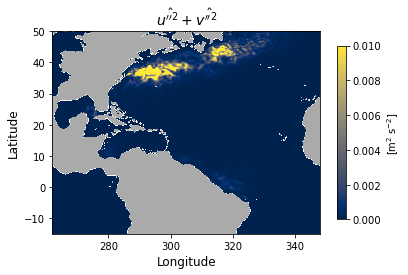

In [27]:
fig, ax = plt.subplots(figsize=(6,4))
# fig.set_tight_layout(True)

im = ax.pcolormesh(ds2.XC, ds2.YC.sel(YC=slice(ystart,yend+12**-1)), 
                   (upp2*vpp2).sel(YC=slice(ystart,yend+12**-1)).isel(delta_outer=23),
                   vmax=.01, vmin=0., 
                   cmap='', rasterized=True)

ax.pcolormesh(ds2.XC, ds2.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(~mask, mask),
              vmin=0, vmax=3, cmap='binary', rasterized=True)

ax.set_title(r"$\hat{{u''}^2} + \hat{{v''}^2}$", fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cb = fig.colorbar(im, ax=ax, shrink=.8)
cb.set_label(r"[m$^2$ s$^{-2}$]")
plt.savefig(op.join(spec,'figure/EKE.pdf'))

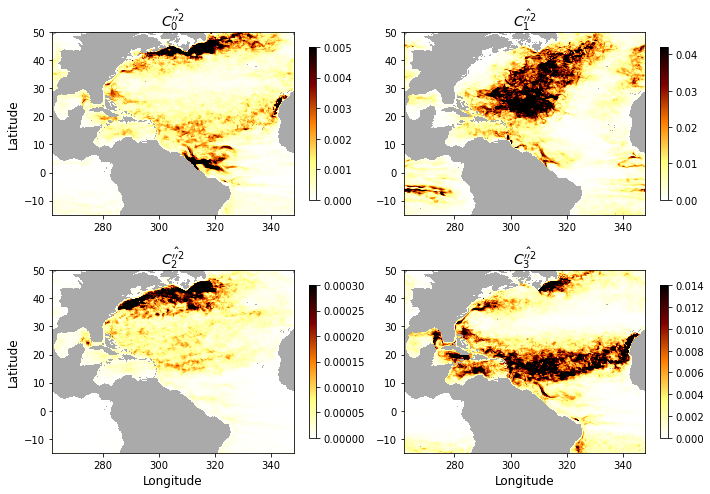

In [40]:
fig, axes = plt.subplots(figsize=(10,7), nrows=2, ncols=2)
fig.set_tight_layout(True)

# im = axes[0,0].pcolormesh(ds2.XC, ds2.YC.sel(YC=slice(ystart,yend+12**-1)), 
#                         (upp2*vpp2).sel(YC=slice(ystart,yend+12**-1)).isel(delta_outer=23),
#                         vmax=.05, vmin=0., 
#                         cmap='cividis', rasterized=True)
cm0 = axes[0,0].pcolormesh(ds2.XC, ds2.YC.sel(YC=slice(ystart,yend+12**-1)), 
                   P0p2.sel(YC=slice(ystart,yend+12**-1)).isel(delta_outer=23), 
                   vmax=.005, vmin=0,
                   cmap='afmhot_r', rasterized=True)
cm1 = axes[0,1].pcolormesh(ds2.XC, ds2.YC.sel(YC=slice(ystart,yend+12**-1)), 
                   P1p2.sel(YC=slice(ystart,yend+12**-1)).isel(delta_outer=23), 
                   vmax=.042, vmin=0,
                   cmap='afmhot_r', rasterized=True)
cm2 = axes[1,0].pcolormesh(ds2.XC, ds2.YC.sel(YC=slice(ystart,yend+12**-1)), 
                   P2p2.sel(YC=slice(ystart,yend+12**-1)).isel(delta_outer=23), 
                   vmax=.0003, vmin=0,
                   cmap='afmhot_r', rasterized=True)
cm3 = axes[1,1].pcolormesh(ds2.XC, ds2.YC.sel(YC=slice(ystart,yend+12**-1)), 
                   P3p2.sel(YC=slice(ystart,yend+12**-1)).isel(delta_outer=23), 
                   vmax=.014, vmin=0,
                   cmap='afmhot_r', rasterized=True)

axes[0,0].pcolormesh(ds2.XC, ds2.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(~mask, mask),
              vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(ds2.XC, ds2.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(~mask, mask),
              vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(ds2.XC, ds2.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(~mask, mask),
              vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(ds2.XC, ds2.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(~mask, mask),
              vmin=0, vmax=3, cmap='binary', rasterized=True)

axes[0,0].set_ylabel('Latitude', fontsize=12)
axes[1,0].set_ylabel('Latitude', fontsize=12)
axes[1,0].set_xlabel('Longitude', fontsize=12)
axes[1,1].set_xlabel('Longitude', fontsize=12)

axes[0,0].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,1].set_aspect('equal')

# axes[0,0].set_title(r"$\hat{{u''}^2} + \hat{{v''}^2}$", fontsize=14)
axes[0,0].set_title(r"$\hat{{C_0''}^2}$", fontsize=14)
axes[0,1].set_title(r"$\hat{{C_1''}^2}$", fontsize=14)
axes[1,0].set_title(r"$\hat{{C_2''}^2}$", fontsize=14)
axes[1,1].set_title(r"$\hat{{C_3''}^2}$", fontsize=14)

cb0 = fig.colorbar(cm0, ax=axes[0,0], shrink=.7)
cb1 = fig.colorbar(cm1, ax=axes[0,1], shrink=.7)
cb2 = fig.colorbar(cm2, ax=axes[1,0], shrink=.7)
cb3 = fig.colorbar(cm3, ax=axes[1,1], shrink=.7)
fig.subplots_adjust(hspace=.16, wspace=.2) 
# cbax = fig.add_axes([0.88, 0.275, 0.015, 0.45])
# cbar = fig.colorbar(cm, cax=cbax, orientation='vertical',  
#                     # ticks=[-np.pi/2,-np.pi/3,-np.pi/6,0,np.pi/6,np.pi/3,np.pi/2]
#                    )
# # cbar.ax.set_yticklabels([
# #     r"$-\pi/2$",r"$-\pi/3$",r"$-\pi/6$",r"$0$",r"$\pi/6$",r"$\pi/3$",r"$\pi/2$"
# # ])
# cbar.set_label(r"[m s$^{-1}$]", fontsize=12)
plt.savefig(op.join(spec,'figure/Pvar.pdf'))